In [1]:
# reference example
from nequip.data import dataset_from_config
from nequip.utils import Config
from nequip.utils.misc import get_default_device_name
from nequip.utils.config import _GLOBAL_ALL_ASKED_FOR_KEYS

from nequip.model import model_from_config


default_config = dict(
    root="./",
    tensorboard=False,
    wandb=False,
    model_builders=[
        "SimpleIrrepsConfig",
        "EnergyModel",
        "PerSpeciesRescale",
        "StressForceOutput",
        "RescaleEnergyEtc",
    ],
    dataset_statistics_stride=1,
    device=get_default_device_name(),
    default_dtype="float64",
    model_dtype="float32",
    allow_tf32=True,
    verbose="INFO",
    model_debug_mode=False,
    equivariance_test=False,
    grad_anomaly_mode=False,
    gpu_oom_offload=False,
    append=False,
    warn_unused=False,
    _jit_bailout_depth=2,  # avoid 20 iters of pain, see https://github.com/pytorch/pytorch/issues/52286
    # Quote from eelison in PyTorch slack:
    # https://pytorch.slack.com/archives/CDZD1FANA/p1644259272007529?thread_ts=1644064449.039479&cid=CDZD1FANA
    # > Right now the default behavior is to specialize twice on static shapes and then on dynamic shapes.
    # > To reduce warmup time you can do something like setFusionStrartegy({{FusionBehavior::DYNAMIC, 3}})
    # > ... Although we would wouldn't really expect to recompile a dynamic shape fusion in a model,
    # > provided broadcasting patterns remain fixed
    # We default to DYNAMIC alone because the number of edges is always dynamic,
    # even if the number of atoms is fixed:
    _jit_fusion_strategy=[("DYNAMIC", 3)],
    # Due to what appear to be ongoing bugs with nvFuser, we default to NNC (fuser1) for now:
    # TODO: still default to NNC on CPU regardless even if change this for GPU
    # TODO: default for ROCm?
    _jit_fuser="fuser1",
)

# All default_config keys are valid / requested
_GLOBAL_ALL_ASKED_FOR_KEYS.update(default_config.keys())

/Users/temporary/anaconda3/envs/torch_mkl/lib/python3.10/site-packages/nequip/__init__.py:20: UserWarning: !! PyTorch version 2.0.0 found. Upstream issues in PyTorch versions 1.13.* and 2.* have been seen to cause unusual performance degredations on some CUDA systems that become worse over time; see https://github.com/mir-group/nequip/discussions/311. The best tested PyTorch version to use with CUDA devices is 1.11; while using other versions if you observe this problem, an unexpected lack of this problem, or other strange behavior, please post in the linked GitHub issue.
  warnings.warn(


In [2]:
config = Config.from_file('./configs/example.yaml', defaults=default_config)
    

dataset = dataset_from_config(config, prefix="dataset")

validation_dataset = None

dataset[0]

AtomicData(atom_types=[15, 1], cell=[3, 3], edge_cell_shift=[152, 3], edge_index=[2, 152], forces=[15, 3], pbc=[3], pos=[15, 3], total_energy=[1])

In [3]:
# Trainer
from nequip.train.trainer import Trainer

trainer = Trainer(model=None, **Config.as_dict(config))

# what is this
# to update wandb data?
config.update(trainer.params)

# = Train/test split =
trainer.set_dataset(dataset, validation_dataset)

# = Build model =
final_model = model_from_config(
    config=config, initialize=True, dataset=trainer.dataset_train
)

Torch device: cpu
/Users/temporary/Documents/GitHub/pytorch-intel-mps/torch/jit/_check.py:172: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "
Replace string dataset_per_atom_total_energy_mean to -11319.556640625
Atomic outputs are scaled by: [H, C: None], shifted by [H, C: -11319.556641].
Replace string dataset_forces_rms to 30.621034622192383
Initially outputs are globally scaled by: 30.621034622192383, total_energy are globally shifted by None.


In [4]:
(96 + 64)*64/2

5120.0

In [5]:
final_model

GraphModel(
  (model): RescaleOutput(
    (model): StressOutput(
      (func): SequentialGraphNetwork(
        (one_hot): OneHotAtomEncoding()
        (spharm_edges): SphericalHarmonicEdgeAttrs(
          (sh): SphericalHarmonics()
        )
        (radial_basis): RadialBasisEdgeEncoding(
          (basis): BesselBasis()
          (cutoff): PolynomialCutoff()
        )
        (chemical_embedding): AtomwiseLinear(
          (linear): Linear(2x0e -> 32x0e | 64 weights)
        )
        (layer0_convnet): ConvNetLayer(
          (equivariant_nonlin): Gate (96x0e+32x1o+32x2e -> 32x0e+32x2e+32x1o)
          (conv): InteractionBlock(
            (linear_1): Linear(32x0e -> 32x0e | 1024 weights)
            (fc): FullyConnectedNet[8, 64, 64, 96]
            (tp): TensorProduct(32x0e x 1x0e+1x1o+1x2e -> 32x0e+32x1o+32x2e | 96 paths | 96 weights)
            (linear_2): Linear(32x0e+32x1o+32x2e -> 96x0e+32x1o+32x2e | 5120 weights)
            (sc): FullyConnectedTensorProduct(32x0e x 2x0e -> 

In [6]:
from nequip.data import AtomicData

out = final_model(AtomicData.to_AtomicDataDict(dataset[0]))

# Dets AtomicDataDict as input and returns AtomicDataDict as output
type(out)

dict

In [7]:
out

{'edge_index': tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,
           1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
           2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,
           4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,
           6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,
           7,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9, 10,
          10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 12,
          12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14,
          14, 14, 14, 14, 14, 14, 14, 14],
         [14,  9,  8, 10,  6,  5,  3,  2,  1,  7,  8, 14, 13, 12, 11,  9,  7, 10,
           5,  4,  3,  2,  0,  6, 14, 13, 12, 11, 10,  9,  8,  7,  5,  4,  3,  1,
           0,  6, 14, 13, 12, 11, 10,  5,  0,  1,  2,  6,  4, 14, 13, 12, 11, 10,
           6,  5,  3,  2,  1, 13, 12, 11,

## GraphModuleMixing

In [8]:
import random
from typing import Dict, Tuple, Callable, Any, Sequence, Union, Mapping, Optional
from collections import OrderedDict

import torch

from e3nn import o3

from nequip.data import AtomicDataDict
from nequip.utils import instantiate


class GraphModuleMixin:
    r"""Mixin parent class for ``torch.nn.Module``s that act on and return ``AtomicDataDict.Type`` graph data.

    All such classes should call ``_init_irreps`` in their ``__init__`` functions with information on the data fields they expect,
    require, and produce, as well as their corresponding irreps.
    """

    def _init_irreps(
        self,
        irreps_in: Dict[str, Any] = {},
        my_irreps_in: Dict[str, Any] = {},
        required_irreps_in: Sequence[str] = [],
        irreps_out: Dict[str, Any] = {},
    ):
        """Setup the expected data fields and their irreps for this graph module.

        ``None`` is a valid irreps in the context for anything that is invariant but not well described by an ``e3nn.o3.Irreps``.
        An example are edge indexes in a graph, which are invariant but are integers, not ``0e`` scalars.

        Args:
            irreps_in (dict): maps names of all input fields from previous modules or
                data to their corresponding irreps
            my_irreps_in (dict): maps names of fields to the irreps they must have for
                this graph module. Will be checked for consistancy with ``irreps_in``
            required_irreps_in: sequence of names of fields that must be present in
                ``irreps_in``, but that can have any irreps.
            irreps_out (dict): mapping names of fields that are modified/output by
                this graph module to their irreps.
        """
        # Coerce
        irreps_in = {} if irreps_in is None else irreps_in
        irreps_in = AtomicDataDict._fix_irreps_dict(irreps_in)
        # positions are *always* 1o, and always present
        if AtomicDataDict.POSITIONS_KEY in irreps_in:
            if irreps_in[AtomicDataDict.POSITIONS_KEY] != o3.Irreps("1x1o"):
                raise ValueError(
                    f"Positions must have irreps 1o, got instead `{irreps_in[AtomicDataDict.POSITIONS_KEY]}`"
                )
        irreps_in[AtomicDataDict.POSITIONS_KEY] = o3.Irreps("1o")
        # edges are also always present
        if AtomicDataDict.EDGE_INDEX_KEY in irreps_in:
            if irreps_in[AtomicDataDict.EDGE_INDEX_KEY] is not None:
                raise ValueError(
                    f"Edge indexes must have irreps None, got instead `{irreps_in[AtomicDataDict.EDGE_INDEX_KEY]}`"
                )
        irreps_in[AtomicDataDict.EDGE_INDEX_KEY] = None

        my_irreps_in = AtomicDataDict._fix_irreps_dict(my_irreps_in)

        irreps_out = AtomicDataDict._fix_irreps_dict(irreps_out)
        # Confirm compatibility:
        # with my_irreps_in
        for k in my_irreps_in:
            if k in irreps_in and irreps_in[k] != my_irreps_in[k]:
                raise ValueError(
                    f"The given input irreps {irreps_in[k]} for field '{k}' is incompatible with this configuration {type(self)}; should have been {my_irreps_in[k]}"
                )
        # with required_irreps_in
        for k in required_irreps_in:
            if k not in irreps_in:
                raise ValueError(
                    f"This {type(self)} requires field '{k}' to be in irreps_in"
                )
        # Save stuff
        self.irreps_in = irreps_in
        # The output irreps of any graph module are whatever inputs it has, overwritten with whatever outputs it has.
        new_out = irreps_in.copy()
        new_out.update(irreps_out)
        self.irreps_out = new_out

    def _add_independent_irreps(self, irreps: Dict[str, Any]):
        """
        Insert some independent irreps that need to be exposed to the self.irreps_in and self.irreps_out.
        The terms that have already appeared in the irreps_in will be removed.

        Args:
            irreps (dict): maps names of all new fields
        """

        irreps = {
            key: irrep for key, irrep in irreps.items() if key not in self.irreps_in
        }
        irreps_in = AtomicDataDict._fix_irreps_dict(irreps)
        irreps_out = AtomicDataDict._fix_irreps_dict(
            {key: irrep for key, irrep in irreps.items() if key not in self.irreps_out}
        )
        self.irreps_in.update(irreps_in)
        self.irreps_out.update(irreps_out)

    def _make_tracing_inputs(self, n):
        # We impliment this to be able to trace graph modules
        out = []
        for _ in range(n):
            batch = random.randint(1, 4)
            # TODO: handle None case
            # TODO: do only required inputs
            # TODO: dummy input if empty?
            out.append(
                {
                    "forward": (
                        {
                            k: i.randn(batch, -1)
                            for k, i in self.irreps_in.items()
                            if i is not None
                        },
                    )
                }
            )
        return out


class SequentialGraphNetwork(GraphModuleMixin, torch.nn.Sequential):
    r"""A ``torch.nn.Sequential`` of ``GraphModuleMixin``s.

    Args:
        modules (list or dict of ``GraphModuleMixin``s): the sequence of graph modules. If a list, the modules will be named ``"module0", "module1", ...``.
    """

    def __init__(
        self,
        modules: Union[Sequence[GraphModuleMixin], Dict[str, GraphModuleMixin]],
    ):
        if isinstance(modules, dict):
            module_list = list(modules.values())
        else:
            module_list = list(modules)
        # check in/out irreps compatible
        for m1, m2 in zip(module_list, module_list[1:]):
            assert AtomicDataDict._irreps_compatible(
                m1.irreps_out, m2.irreps_in
            ), f"Incompatible irreps_out from {type(m1).__name__} for input to {type(m2).__name__}: {m1.irreps_out} -> {m2.irreps_in}"
        self._init_irreps(
            irreps_in=module_list[0].irreps_in,
            my_irreps_in=module_list[0].irreps_in,
            irreps_out=module_list[-1].irreps_out,
        )
        # torch.nn.Sequential will name children correctly if passed an OrderedDict
        if isinstance(modules, dict):
            modules = OrderedDict(modules)
        else:
            modules = OrderedDict((f"module{i}", m) for i, m in enumerate(module_list))
        super().__init__(modules)

    @classmethod
    def from_parameters(
        cls,
        shared_params: Mapping,
        layers: Dict[str, Union[Callable, Tuple[Callable, Dict[str, Any]]]],
        irreps_in: Optional[dict] = None,
    ):
        r"""Construct a ``SequentialGraphModule`` of modules built from a shared set of parameters.

        For some layer, a parameter with name ``param`` will be taken, in order of priority, from:
          1. The specific value in the parameter dictionary for that layer, if provided
          2. ``name_param`` in ``shared_params`` where ``name`` is the name of the layer
          3. ``param`` in ``shared_params``

        Args:
            shared_params (dict-like): shared parameters from which to pull when instantiating the module
            layers (dict): dictionary mapping unique names of layers to either:
                  1. A callable (such as a class or function) that can be used to ``instantiate`` a module for that layer
                  2. A tuple of such a callable and a dictionary mapping parameter names to values. The given dictionary of parameters will override for this layer values found in ``shared_params``.
                Options 1. and 2. can be mixed.
            irreps_in (optional dict): ``irreps_in`` for the first module in the sequence.

        Returns:
            The constructed SequentialGraphNetwork.
        """
        # note that dictionary ordered gueranteed in >=3.7, so its fine to do an ordered sequential as a dict.
        built_modules = []
        for name, builder in layers.items():
            if not isinstance(name, str):
                raise ValueError(f"`'name'` must be a str; got `{name}`")
            if isinstance(builder, tuple):
                builder, params = builder
            else:
                params = {}
            if not callable(builder):
                raise TypeError(
                    f"The builder has to be a class or a function. got {type(builder)}"
                )

            instance, _ = instantiate(
                builder=builder,
                prefix=name,
                positional_args=(
                    dict(
                        irreps_in=(
                            built_modules[-1].irreps_out
                            if len(built_modules) > 0
                            else irreps_in
                        )
                    )
                ),
                optional_args=params,
                all_args=shared_params,
            )

            if not isinstance(instance, GraphModuleMixin):
                raise TypeError(
                    f"Builder `{builder}` for layer with name `{name}` did not return a GraphModuleMixin, instead got a {type(instance).__name__}"
                )

            built_modules.append(instance)

        return cls(
            OrderedDict(zip(layers.keys(), built_modules)),
        )

    @torch.jit.unused
    def append(self, name: str, module: GraphModuleMixin) -> None:
        r"""Append a module to the SequentialGraphNetwork.

        Args:
            name (str): the name for the module
            module (GraphModuleMixin): the module to append
        """
        assert AtomicDataDict._irreps_compatible(self.irreps_out, module.irreps_in)
        self.add_module(name, module)
        self.irreps_out = dict(module.irreps_out)
        return

    @torch.jit.unused
    def append_from_parameters(
        self,
        shared_params: Mapping,
        name: str,
        builder: Callable,
        params: Dict[str, Any] = {},
    ) -> GraphModuleMixin:
        r"""Build a module from parameters and append it.

        Args:
            shared_params (dict-like): shared parameters from which to pull when instantiating the module
            name (str): the name for the module
            builder (callable): a class or function to build a module
            params (dict, optional): extra specific parameters for this module that take priority over those in ``shared_params``

        Returns:
            the build module
        """
        instance, _ = instantiate(
            builder=builder,
            prefix=name,
            positional_args=(dict(irreps_in=self[-1].irreps_out)),
            optional_args=params,
            all_args=shared_params,
        )
        self.append(name, instance)
        return instance

    @torch.jit.unused
    def insert(
        self,
        name: str,
        module: GraphModuleMixin,
        after: Optional[str] = None,
        before: Optional[str] = None,
    ) -> None:
        """Insert a module after the module with name ``after``.

        Args:
            name: the name of the module to insert
            module: the moldule to insert
            after: the module to insert after
            before: the module to insert before
        """

        if (before is None) is (after is None):
            raise ValueError("Only one of before or after argument needs to be defined")
        elif before is None:
            insert_location = after
        else:
            insert_location = before

        # This checks names, etc.
        self.add_module(name, module)
        # Now insert in the right place by overwriting
        names = list(self._modules.keys())
        modules = list(self._modules.values())
        idx = names.index(insert_location)
        if before is None:
            idx += 1
        names.insert(idx, name)
        modules.insert(idx, module)

        self._modules = OrderedDict(zip(names, modules))

        module_list = list(self._modules.values())

        # sanity check the compatibility
        if idx > 0:
            assert AtomicDataDict._irreps_compatible(
                module_list[idx - 1].irreps_out, module.irreps_in
            )
        if len(module_list) > idx:
            assert AtomicDataDict._irreps_compatible(
                module_list[idx + 1].irreps_in, module.irreps_out
            )

        # insert the new irreps_out to the later modules
        for module_id, next_module in enumerate(module_list[idx + 1 :]):
            next_module._add_independent_irreps(module.irreps_out)

        # update the final wrapper irreps_out
        self.irreps_out = dict(module_list[-1].irreps_out)

        return

    @torch.jit.unused
    def insert_from_parameters(
        self,
        shared_params: Mapping,
        name: str,
        builder: Callable,
        params: Dict[str, Any] = {},
        after: Optional[str] = None,
        before: Optional[str] = None,
    ) -> GraphModuleMixin:
        r"""Build a module from parameters and insert it after ``after``.

        Args:
            shared_params (dict-like): shared parameters from which to pull when instantiating the module
            name (str): the name for the module
            builder (callable): a class or function to build a module
            params (dict, optional): extra specific parameters for this module that take priority over those in ``shared_params``
            after: the name of the module to insert after
            before: the name of the module to insert before

        Returns:
            the inserted module
        """
        if (before is None) is (after is None):
            raise ValueError("Only one of before or after argument needs to be defined")
        elif before is None:
            insert_location = after
        else:
            insert_location = before
        idx = list(self._modules.keys()).index(insert_location) - 1
        if before is None:
            idx += 1
        instance, _ = instantiate(
            builder=builder,
            prefix=name,
            positional_args=(dict(irreps_in=self[idx].irreps_out)),
            optional_args=params,
            all_args=shared_params,
        )
        self.insert(after=after, before=before, name=name, module=instance)
        return instance

    # Copied from https://pytorch.org/docs/stable/_modules/torch/nn/modules/container.html#Sequential
    # with type annotations added
    def forward(self, input: AtomicDataDict.Type) -> AtomicDataDict.Type:
        for module in self:
            input = module(input)
        return input

In [9]:
import torch
import torch.nn.functional

from e3nn.o3 import Irreps
from e3nn.util.jit import compile_mode

from nequip.data import AtomicDataDict
#from .._graph_mixin import GraphModuleMixin


@compile_mode("script")
class OneHotAtomEncoding(GraphModuleMixin, torch.nn.Module):
    """Copmute a one-hot floating point encoding of atoms' discrete atom types.

    Args:
        set_features: If ``True`` (default), ``node_features`` will be set in addition to ``node_attrs``.
    """

    num_types: int
    set_features: bool

    def __init__(
        self,
        num_types: int,
        set_features: bool = True,
        irreps_in=None,
    ):
        super().__init__()
        self.num_types = num_types
        self.set_features = set_features
        # Output irreps are num_types even (invariant) scalars
        irreps_out = {AtomicDataDict.NODE_ATTRS_KEY: Irreps([(self.num_types, (0, 1))])}
        if self.set_features:
            irreps_out[AtomicDataDict.NODE_FEATURES_KEY] = irreps_out[
                AtomicDataDict.NODE_ATTRS_KEY
            ]
        self._init_irreps(irreps_in=irreps_in, irreps_out=irreps_out)

    def forward(self, data: AtomicDataDict.Type) -> AtomicDataDict.Type:
        type_numbers = data[AtomicDataDict.ATOM_TYPE_KEY].squeeze(-1)
        one_hot = torch.nn.functional.one_hot(
            type_numbers, num_classes=self.num_types
        ).to(device=type_numbers.device, dtype=data[AtomicDataDict.POSITIONS_KEY].dtype)
        data[AtomicDataDict.NODE_ATTRS_KEY] = one_hot
        if self.set_features:
            data[AtomicDataDict.NODE_FEATURES_KEY] = one_hot
        return data

In [10]:
# One hot encoding of the types
one_hot = OneHotAtomEncoding(2)

out1 = one_hot(AtomicData.to_AtomicDataDict(dataset[0]))

out1.keys()

dict_keys(['edge_index', 'pos', 'pbc', 'forces', 'total_energy', 'cell', 'edge_cell_shift', 'atom_types', 'node_attrs', 'node_features'])

In [11]:
one_hot.irreps_in, one_hot.irreps_out

({'pos': 1x1o, 'edge_index': None},
 {'pos': 1x1o, 'edge_index': None, 'node_attrs': 2x0e, 'node_features': 2x0e})

In [12]:
from e3nn.o3 import Linear

class AtomwiseLinear(GraphModuleMixin, torch.nn.Module):
    def __init__(
        self,
        field: str = AtomicDataDict.NODE_FEATURES_KEY,
        out_field: Optional[str] = None,
        irreps_in=None,
        irreps_out=None,
    ):
        super().__init__()
        self.field = field
        out_field = out_field if out_field is not None else field
        self.out_field = out_field
        if irreps_out is None:
            irreps_out = irreps_in[field]

        self._init_irreps(
            irreps_in=irreps_in,
            required_irreps_in=[field],
            irreps_out={out_field: irreps_out},
        )
        self.linear = Linear(
            irreps_in=self.irreps_in[field], irreps_out=self.irreps_out[out_field]
        )

    def forward(self, data: AtomicDataDict.Type) -> AtomicDataDict.Type:
        data[self.out_field] = self.linear(data[self.field])
        return data

In [14]:
al = AtomwiseLinear(irreps_in=one_hot.irreps_out, irreps_out=o3.Irreps([(32, (0, 1))]))

out2 = al(out1)

print(out2.keys())

al.irreps_out

dict_keys(['edge_index', 'pos', 'pbc', 'forces', 'total_energy', 'cell', 'edge_cell_shift', 'atom_types', 'node_attrs', 'node_features'])


{'pos': 1x1o, 'edge_index': None, 'node_attrs': 2x0e, 'node_features': 32x0e}

In [15]:
from typing import Optional
import math

import torch

from torch import nn

from e3nn.math import soft_one_hot_linspace
from e3nn.util.jit import compile_mode

class BesselBasis(nn.Module):
    r_max: float
    prefactor: float

    def __init__(self, r_max, num_basis=8, trainable=True):
        r"""Radial Bessel Basis, as proposed in DimeNet: https://arxiv.org/abs/2003.03123


        Parameters
        ----------
        r_max : float
            Cutoff radius

        num_basis : int
            Number of Bessel Basis functions

        trainable : bool
            Train the :math:`n \pi` part or not.
        """
        super(BesselBasis, self).__init__()

        self.trainable = trainable
        self.num_basis = num_basis

        self.r_max = float(r_max)
        self.prefactor = 2.0 / self.r_max

        bessel_weights = (
            torch.linspace(start=1.0, end=num_basis, steps=num_basis) * math.pi
        )
        if self.trainable:
            self.bessel_weights = nn.Parameter(bessel_weights)
        else:
            self.register_buffer("bessel_weights", bessel_weights)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Evaluate Bessel Basis for input x.

        Parameters
        ----------
        x : torch.Tensor
            Input
        """
        numerator = torch.sin(self.bessel_weights * x.unsqueeze(-1) / self.r_max)

        return self.prefactor * (numerator / x.unsqueeze(-1))


import torch


@torch.jit.script
def _poly_cutoff(x: torch.Tensor, factor: float, p: float = 6.0) -> torch.Tensor:
    x = x * factor

    out = 1.0
    out = out - (((p + 1.0) * (p + 2.0) / 2.0) * torch.pow(x, p))
    out = out + (p * (p + 2.0) * torch.pow(x, p + 1.0))
    out = out - ((p * (p + 1.0) / 2) * torch.pow(x, p + 2.0))

    return out * (x < 1.0)


class PolynomialCutoff(torch.nn.Module):
    _factor: float
    p: float

    def __init__(self, r_max: float, p: float = 6):
        r"""Polynomial cutoff, as proposed in DimeNet: https://arxiv.org/abs/2003.03123


        Parameters
        ----------
        r_max : float
            Cutoff radius

        p : int
            Power used in envelope function
        """
        super().__init__()
        assert p >= 2.0
        self.p = float(p)
        self._factor = 1.0 / float(r_max)

    def forward(self, x):
        """
        Evaluate cutoff function.

        x: torch.Tensor, input distance
        """
        return _poly_cutoff(x, self._factor, p=self.p)

In [16]:
from typing import Union

import torch

from e3nn import o3
from e3nn.util.jit import compile_mode

from nequip.data import AtomicDataDict
#from .._graph_mixin import GraphModuleMixin
#from ..radial_basis import BesselBasis
#from ..cutoffs import PolynomialCutoff




@compile_mode("script")
class SphericalHarmonicEdgeAttrs(GraphModuleMixin, torch.nn.Module):
    """Construct edge attrs as spherical harmonic projections of edge vectors.

    Parameters follow ``e3nn.o3.spherical_harmonics``.

    Args:
        irreps_edge_sh (int, str, or o3.Irreps): if int, will be treated as lmax for o3.Irreps.spherical_harmonics(lmax)
        edge_sh_normalization (str): the normalization scheme to use
        edge_sh_normalize (bool, default: True): whether to normalize the spherical harmonics
        out_field (str, default: AtomicDataDict.EDGE_ATTRS_KEY: data/irreps field
    """

    out_field: str

    def __init__(
        self,
        irreps_edge_sh: Union[int, str, o3.Irreps],
        edge_sh_normalization: str = "component",
        edge_sh_normalize: bool = True,
        irreps_in=None,
        out_field: str = AtomicDataDict.EDGE_ATTRS_KEY,
    ):
        super().__init__()
        self.out_field = out_field

        if isinstance(irreps_edge_sh, int):
            self.irreps_edge_sh = o3.Irreps.spherical_harmonics(irreps_edge_sh)
        else:
            self.irreps_edge_sh = o3.Irreps(irreps_edge_sh)
        self._init_irreps(
            irreps_in=irreps_in,
            irreps_out={out_field: self.irreps_edge_sh},
        )
        self.sh = o3.SphericalHarmonics(
            self.irreps_edge_sh, edge_sh_normalize, edge_sh_normalization
        )

    def forward(self, data: AtomicDataDict.Type) -> AtomicDataDict.Type:
        data = AtomicDataDict.with_edge_vectors(data, with_lengths=False)
        edge_vec = data[AtomicDataDict.EDGE_VECTORS_KEY]
        edge_sh = self.sh(edge_vec)
        data[self.out_field] = edge_sh
        return data


@compile_mode("script")
class RadialBasisEdgeEncoding(GraphModuleMixin, torch.nn.Module):
    out_field: str

    def __init__(
        self,
        basis=BesselBasis,
        cutoff=PolynomialCutoff,
        basis_kwargs={},
        cutoff_kwargs={},
        out_field: str = AtomicDataDict.EDGE_EMBEDDING_KEY,
        irreps_in=None,
    ):
        super().__init__()
        self.basis = basis(**basis_kwargs)
        self.cutoff = cutoff(**cutoff_kwargs)
        self.out_field = out_field
        self._init_irreps(
            irreps_in=irreps_in,
            irreps_out={
                self.out_field: o3.Irreps([(self.basis.num_basis, (0, 1))]),
                AtomicDataDict.EDGE_CUTOFF_KEY: "0e",
            },
        )

    def forward(self, data: AtomicDataDict.Type) -> AtomicDataDict.Type:
        data = AtomicDataDict.with_edge_vectors(data, with_lengths=True)
        edge_length = data[AtomicDataDict.EDGE_LENGTH_KEY]
        cutoff = self.cutoff(edge_length).unsqueeze(-1)
        edge_length_embedded = self.basis(edge_length) * cutoff
        data[self.out_field] = edge_length_embedded
        data[AtomicDataDict.EDGE_CUTOFF_KEY] = cutoff
        return data


@compile_mode("script")
class AddRadialCutoffToData(GraphModuleMixin, torch.nn.Module):
    def __init__(
        self,
        cutoff=PolynomialCutoff,
        cutoff_kwargs={},
        irreps_in=None,
    ):
        super().__init__()
        self.cutoff = cutoff(**cutoff_kwargs)
        self._init_irreps(
            irreps_in=irreps_in, irreps_out={AtomicDataDict.EDGE_CUTOFF_KEY: "0e"}
        )

    def forward(self, data: AtomicDataDict.Type) -> AtomicDataDict.Type:
        data = AtomicDataDict.with_edge_vectors(data, with_lengths=True)
        edge_length = data[AtomicDataDict.EDGE_LENGTH_KEY]
        cutoff = self.cutoff(edge_length).unsqueeze(-1)
        data[AtomicDataDict.EDGE_CUTOFF_KEY] = cutoff
        return data

In [17]:
sh = SphericalHarmonicEdgeAttrs(2, irreps_in=al.irreps_out)

out3 = sh(out2); print(out3.keys())
sh.irreps_out

dict_keys(['edge_index', 'pos', 'pbc', 'forces', 'total_energy', 'cell', 'edge_cell_shift', 'atom_types', 'node_attrs', 'node_features', 'edge_vectors', 'edge_attrs'])


{'pos': 1x1o,
 'edge_index': None,
 'node_attrs': 2x0e,
 'node_features': 32x0e,
 'edge_attrs': 1x0e+1x1o+1x2e}

In [18]:
rad_basis = RadialBasisEdgeEncoding(basis_kwargs={'num_basis': 6, 'r_max': 5}, cutoff_kwargs={'r_max': 5})

out3 = rad_basis(out2)

out3.keys()

rad_basis.irreps_out

{'pos': 1x1o, 'edge_index': None, 'edge_embedding': 6x0e, 'edge_cutoff': 1x0e}

In [19]:
al = AtomwiseLinear(irreps_in=one_hot.irreps_out, irreps_out=o3.Irreps([(32, (0, 1))]))

out4 = rad_basis(out3)

print(out4.keys())

al.irreps_out

dict_keys(['edge_index', 'pos', 'pbc', 'forces', 'total_energy', 'cell', 'edge_cell_shift', 'atom_types', 'node_attrs', 'node_features', 'edge_vectors', 'edge_attrs', 'edge_lengths', 'edge_embedding', 'edge_cutoff'])


{'pos': 1x1o, 'edge_index': None, 'node_attrs': 2x0e, 'node_features': 32x0e}

In [20]:
from typing import Dict, Callable
import torch
import logging

from e3nn import o3
from e3nn.nn import Gate, NormActivation

from nequip.data import AtomicDataDict
from nequip.nn import (
    GraphModuleMixin,
    InteractionBlock,
)
from nequip.nn.nonlinearities import ShiftedSoftPlus
from nequip.utils.tp_utils import tp_path_exists


acts = {
    "abs": torch.abs,
    "tanh": torch.tanh,
    "ssp": ShiftedSoftPlus,
    "silu": torch.nn.functional.silu,
}


class ConvNetLayer(GraphModuleMixin, torch.nn.Module):
    """
    Args:

    """

    resnet: bool

    def __init__(
        self,
        irreps_in,
        feature_irreps_hidden,
        convolution=InteractionBlock,
        convolution_kwargs: dict = {},
        num_layers: int = 3,
        resnet: bool = False,
        nonlinearity_type: str = "gate",
        nonlinearity_scalars: Dict[int, Callable] = {"e": "silu", "o": "tanh"},
        nonlinearity_gates: Dict[int, Callable] = {"e": "silu", "o": "tanh"},
    ):
        super().__init__()
        # initialization
        assert nonlinearity_type in ("gate", "norm")
        # make the nonlin dicts from parity ints instead of convinience strs
        nonlinearity_scalars = {
            1: nonlinearity_scalars["e"],
            -1: nonlinearity_scalars["o"],
        }
        nonlinearity_gates = {
            1: nonlinearity_gates["e"],
            -1: nonlinearity_gates["o"],
        }

        self.feature_irreps_hidden = o3.Irreps(feature_irreps_hidden)
        self.resnet = resnet
        self.num_layers = num_layers

        # We'll set irreps_out later when we know them
        self._init_irreps(
            irreps_in=irreps_in,
            required_irreps_in=[AtomicDataDict.NODE_FEATURES_KEY],
        )

        edge_attr_irreps = self.irreps_in[AtomicDataDict.EDGE_ATTRS_KEY]
        irreps_layer_out_prev = self.irreps_in[AtomicDataDict.NODE_FEATURES_KEY]

        irreps_scalars = o3.Irreps(
            [
                (mul, ir)
                for mul, ir in self.feature_irreps_hidden
                if ir.l == 0
                and tp_path_exists(irreps_layer_out_prev, edge_attr_irreps, ir)
            ]
        )

        irreps_gated = o3.Irreps(
            [
                (mul, ir)
                for mul, ir in self.feature_irreps_hidden
                if ir.l > 0
                and tp_path_exists(irreps_layer_out_prev, edge_attr_irreps, ir)
            ]
        )

        irreps_layer_out = (irreps_scalars + irreps_gated).simplify()

        if nonlinearity_type == "gate":
            ir = (
                "0e"
                if tp_path_exists(irreps_layer_out_prev, edge_attr_irreps, "0e")
                else "0o"
            )
            irreps_gates = o3.Irreps([(mul, ir) for mul, _ in irreps_gated])

            # TO DO, it's not that safe to directly use the
            # dictionary
            equivariant_nonlin = Gate(
                irreps_scalars=irreps_scalars,
                act_scalars=[
                    acts[nonlinearity_scalars[ir.p]] for _, ir in irreps_scalars
                ],
                irreps_gates=irreps_gates,
                act_gates=[acts[nonlinearity_gates[ir.p]] for _, ir in irreps_gates],
                irreps_gated=irreps_gated,
            )

            conv_irreps_out = equivariant_nonlin.irreps_in.simplify()

        else:
            conv_irreps_out = irreps_layer_out.simplify()

            equivariant_nonlin = NormActivation(
                irreps_in=conv_irreps_out,
                # norm is an even scalar, so use nonlinearity_scalars[1]
                scalar_nonlinearity=acts[nonlinearity_scalars[1]],
                normalize=True,
                epsilon=1e-8,
                bias=False,
            )

        self.equivariant_nonlin = equivariant_nonlin

        # TODO: partial resnet?
        if irreps_layer_out == irreps_layer_out_prev and resnet:
            # We are doing resnet updates and can for this layer
            self.resnet = True
        else:
            self.resnet = False

        # TODO: last convolution should go to explicit irreps out
        logging.debug(
            f" parameters used to initialize {convolution.__name__}={convolution_kwargs}"
        )

        # override defaults for irreps:
        convolution_kwargs.pop("irreps_in", None)
        convolution_kwargs.pop("irreps_out", None)
        self.conv = convolution(
            irreps_in=self.irreps_in,
            irreps_out=conv_irreps_out,
            **convolution_kwargs,
        )

        # The output features are whatever we got in
        # updated with whatever the convolution outputs (which is a full graph module)
        self.irreps_out.update(self.conv.irreps_out)
        # but with the features updated by the nonlinearity
        self.irreps_out[AtomicDataDict.NODE_FEATURES_KEY] = (
            self.equivariant_nonlin.irreps_out
        )

    # All before complex stuff is preparation, the actual is this part and it is pretty simple
    # 1. conv
    # 2. equiv nonlinear
    # 3. add features from prev layer
    def forward(self, data: AtomicDataDict.Type) -> AtomicDataDict.Type:
        # save old features for resnet
        old_x = data[AtomicDataDict.NODE_FEATURES_KEY]
        # run convolution
        data = self.conv(data)
        # do nonlinearity
        data[AtomicDataDict.NODE_FEATURES_KEY] = self.equivariant_nonlin(
            data[AtomicDataDict.NODE_FEATURES_KEY]
        )
        # do resnet
        if self.resnet:
            data[AtomicDataDict.NODE_FEATURES_KEY] = (
                old_x + data[AtomicDataDict.NODE_FEATURES_KEY]
            )
        return data

### Trying to replicate with e3nn

In [21]:
from e3nn import o3

FullyConnectedTensorProduct(32x0e x 2x0e -> 96x0e+32x1o+32x2e | 6144 paths | 6144 weights) needs 6144 weights


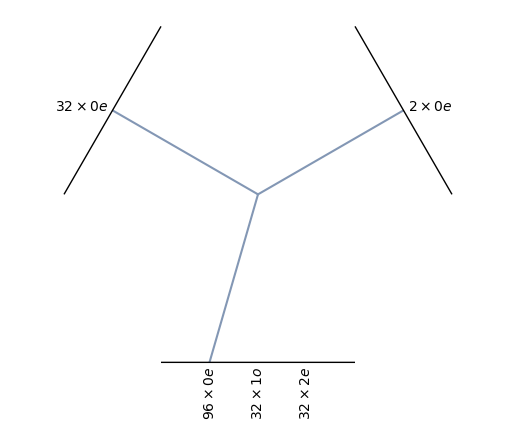

In [39]:
irreps_input = '32x0e'
irreps_sh = '2x0e'
irreps_output = '96x0e + 32x1o + 32x2e'

tp = o3.FullyConnectedTensorProduct(irreps_input, irreps_sh, irreps_output, shared_weights=True)

print(f"{tp} needs {tp.weight_numel} weights")


# No coupling to other than 0
tp.visualize();

FullyConnectedTensorProduct(32x0e+32x2e+32x1o x 2x0e -> 160x0e+32x1o+32x1e+32x2o+32x2e | 14336 paths | 14336 weights) needs 14336 weights


/Users/temporary/Documents/GitHub/pytorch-intel-mps/torch/jit/_check.py:172: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


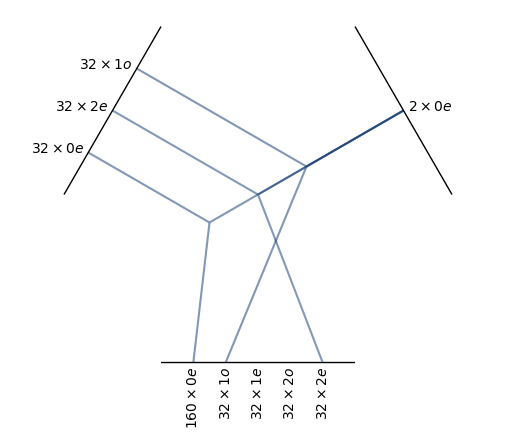

In [42]:
irreps_input = "32x0e+32x2e+32x1o"
irreps_sh = "2x0e"
irreps_output = "160x0e+32x1o+32x1e+32x2o+32x2e"


tp = o3.FullyConnectedTensorProduct(irreps_input, irreps_sh, irreps_output, shared_weights=True)

print(f"{tp} needs {tp.weight_numel} weights")


# No coupling to other than 0
tp.visualize();

In [41]:
tp.weight

Parameter containing:
tensor([ 0.4269,  0.4144,  0.6796,  ...,  0.4213, -0.1014, -1.6700],
       requires_grad=True)